### Shivanka Priyashan
### Index No : 190476V

#### Question 01

In [1]:
import numpy as np
import cv2 as cv
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt

N = 100
half_n = N//2
r = 10
s = r /16
t = np.random.uniform (0 , 2*np.pi , half_n )
n = s*np.random.randn( half_n )
x , y = (r + n)*np.cos(t) , (r + n)*np.sin(t)
X_circ = np.hstack(( x.reshape(half_n , 1 ) , y.reshape (half_n , 1 )))
m, b = -1, 2
x = np.linspace (-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack(( x.reshape ( half_n , 1 ) , y.reshape ( half_n , 1 ) ) )
X = np.vstack ( ( X_line ,X_circ  ) )


#plt.figure(figsize=(16,16))
#for point in X:
#    plt.scatter(point[0],point[1])
#    plt.axis("equal")
#plt.show()

C:\Users\acer\AppData\Local\Temp/ipykernel_23432/4128740271.py:22: RuntimeWarning: invalid value encountered in double_scalars
  distance = abs((a*X[i][0] + b*X[i][1] + c)/ (np.sqrt(a**2 + b**2)) )


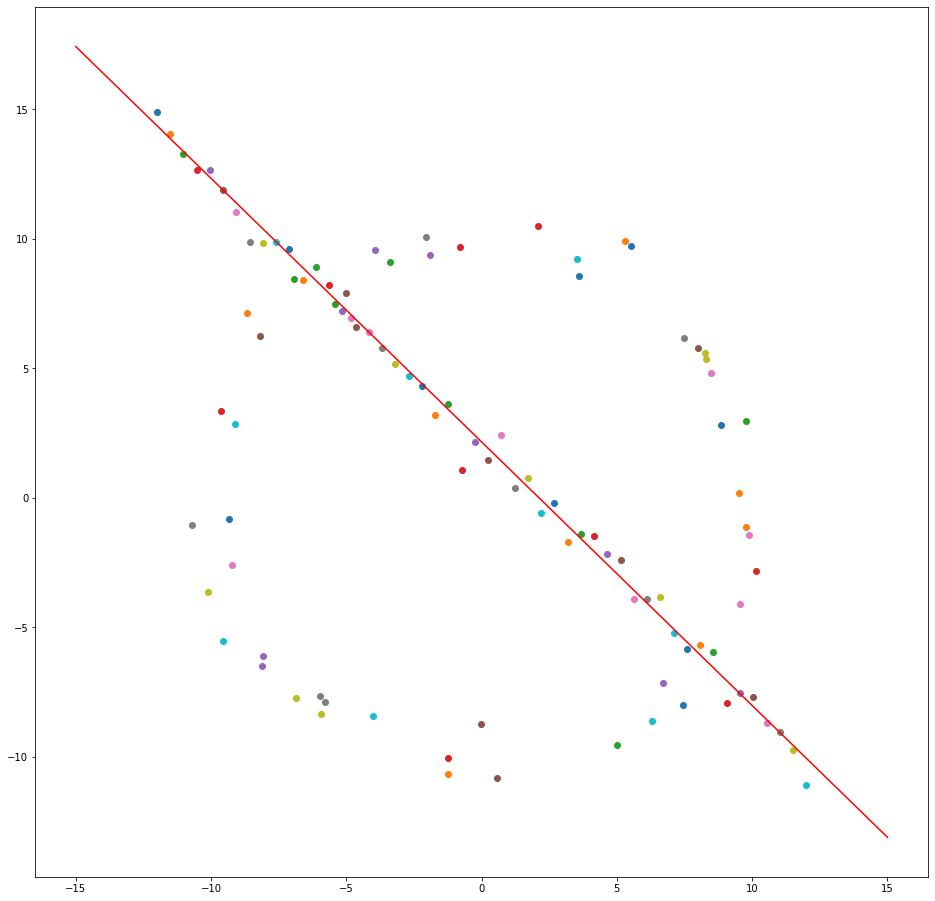

Number of Samples = 600
Inlinear Count = 47


In [2]:
import random

s = 2
t = 0.5
e = 0.3
p = 0.99
N = int (np.log(1-p) / np.log(1 - (1-e)**s)) * 100

max_inlinear_count = 0
coefficients = []

for sample in range(0 , N+1):
    dot1 , dot2 = random.randint(0,len(X)-1), random.randint(0,len(X)-1)
    # equation of a line passing the 2 points ; (y1-y2).X + (x2-x1).Y + (x1.y2 - y1.x2) = 0 
    a = X[dot1][1] - X[dot2][1]
    b = X[dot2][0] - X[dot1][0]
    c = X[dot1][0]*X[dot2][1]  - X[dot1][1]*X[dot2][0]

    # find the count of the points lying withing the threshold (t)
    inlinears_count = 0
    for  i in range(0 , len(X)):
        distance = abs((a*X[i][0] + b*X[i][1] + c)/ (np.sqrt(a**2 + b**2)) )
        if distance < t:
            inlinears_count += 1

    if inlinears_count > max_inlinear_count:
        max_inlinear_count = inlinears_count
        coefficients = [ a, b, c]

plt.figure(figsize=(16,16))
for point in X:
    plt.scatter(point[0],point[1])

A , B , C = coefficients[0] , coefficients[1] , coefficients[2]
x_values = np.arange(-15,15+1)
y_values = -1*(x_values*A +C)/B

plt.plot(x_values, y_values , color="red")
plt.show()
print("Number of Samples =",N)
print("Inlinear Count =",max_inlinear_count)